In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim
import warnings
import numpy as np
from torch.nn import Parameter
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from PIL import Image

warnings.filterwarnings('ignore') 
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [9]:
class BIRADSDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.samples = []
        
        for label in self.classes:
            patient_dirs = os.listdir(os.path.join(root_dir, label))
            for patient_id in patient_dirs:
                patient_dir = os.path.join(root_dir, label, patient_id)
                images = os.listdir(patient_dir)
                if len(images) == 2:  
                    image_paths = [os.path.join(patient_dir, img) for img in images]
                    self.samples.append((image_paths, label))
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_paths, label = self.samples[idx]
        images = [Image.open(img_path).convert('RGB') for img_path in image_paths]
        
        if self.transform:
            images = [self.transform(img) for img in images]
  
        label = 0 if 'BIRADS12' in label else 1 
        
        return (images[0], images[1]), label

In [ ]:
data_dir = "BIRADS12_45DatasetwTest"
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')
# Transforms
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2),
    transforms.Resize((520, 520)),
    transforms.RandomCrop((500, 500)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
valid_transforms = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = BIRADSDataset(train_dir, transform=train_transforms)
valid_dataset = BIRADSDataset(valid_dir, transform=valid_transforms)
test_dataset = BIRADSDataset(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [11]:
train_dataset.classes

['BIRADS12', 'BIRADS45']

In [12]:
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

585
75
20


In [13]:
valid_dataset.classes

['BIRADS12', 'BIRADS45']

In [14]:
test_dataset.classes

['BIRADS12', 'BIRADS45']

### DenseNet121 and DenseNet161 with WDC classifier head

In [ ]:
class WeightedDoubleClassifier(nn.Module):
    def __init__(self, in_features, out_features, n=2):
        super(WeightedDoubleClassifier, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n = n
        self.base = 1000.0
        self.iter = 0
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
    
    def forward(self, input, label):
        self.iter += 1

        cos_theta = F.linear(F.normalize(input), F.normalize(self.weight))
        cos_theta = cos_theta.clamp(-1, 1)
        theta = cos_theta.data.acos() 

        phi1 = torch.cat([cos_theta[:,0].view(-1,1)*self.n, cos_theta[:,1].view(-1,1)],dim=1)
        phi2 = torch.cat([cos_theta[:,0].view(-1,1), cos_theta[:,1].view(-1,1)*self.n,],dim=1)
        output1 =  phi1 * torch.norm(input, 2, 1).view(-1, 1)
        output2 = phi2 * torch.norm(input, 2, 1).view(-1, 1)
        output_std = cos_theta * torch.norm(input, 2, 1).view(-1, 1)
        return output1, output2, output_std

In [9]:
class CNN_DenseNet121(nn.Module): 
    def __init__(self, model):
        super(CNN_DenseNet121, self).__init__()
        self.densenet_layer = nn.Sequential(*list(model.children())[:-1])
        self.avp_pooling = nn.AdaptiveAvgPool2d((1, 1)) 
        self.linear_layer1 = nn.Linear(2048, 1024) 
        self.linear_layer2 = WeightedDoubleClassifier(1024, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, img1, img2, label):
        # first image
        x1 = self.densenet_layer(img1)
        x1 = self.avp_pooling(x1).view(x1.size()[0], -1)

        # second image
        x2 = self.densenet_layer(img2)
        x2 = self.avp_pooling(x2).view(x2.size()[0], -1)

        x = torch.cat((x1, x2), dim=1)
        x = self.dropout(x)
        x = self.relu(self.linear_layer1(x))
        x = self.dropout(x)
        x1, x2, x_std = self.linear_layer2(x, label)

        return x1, x2, x_std
    
class CNN_DenseNet161(nn.Module): 
    def __init__(self, model):
        super(CNN_DenseNet161, self).__init__()
        self.densenet_layer = nn.Sequential(*list(model.children())[:-1])
        self.avp_pooling = nn.AdaptiveAvgPool2d((1, 1)) 
        self.linear_layer1 = nn.Linear(4416, 1024) 
        self.linear_layer2 = WeightedDoubleClassifier(1024, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, img1, img2, label):
        # first image
        x1 = self.densenet_layer(img1)
        x1 = self.avp_pooling(x1).view(x1.size()[0], -1)

        # second image
        x2 = self.densenet_layer(img2)
        x2 = self.avp_pooling(x2).view(x2.size()[0], -1)

        x = torch.cat((x1, x2), dim=1)
        x = self.dropout(x)
        x = self.relu(self.linear_layer1(x))
        x = self.dropout(x)
        x1, x2, x_std = self.linear_layer2(x, label)

        return x1, x2, x_std

def weight_loss(output1, output2, label):
    loss1 = 0.
    loss2 = 0.
    pred1 = output1.argmax(dim=1, keepdim = True)
    pred2 = output2.argmax(dim=1, keepdim = True)
    for i in range(len(pred1)): 
        if pred1[i] == pred2[i]:
            loss1 += -label[i] * torch.log_softmax(output1[i], -1)[1]-(1-label[i]) * torch.log_softmax(output1[i], -1)[0]  #+ 1e-10
            loss2 += -label[i] * torch.log_softmax(output2[i], -1)[1]-(1-label[i]) * torch.log_softmax(output2[i], -1)[0]
        else:
            alpha_weight = 2. - torch.abs(torch.softmax(output1[i], -1)[1]-torch.softmax(output2[i], -1)[1])
            if label[i] == pred2[i]:
                loss1 += (-label[i] * torch.log_softmax(output1[i], -1)[1]-(1-label[i]) * torch.log_softmax(output1[i], -1)[0]) * alpha_weight
            else:
                loss2 += (-label[i] * torch.log_softmax(output2[i], -1)[1]-(1-label[i]) * torch.log_softmax(output2[i], -1)[0]) * alpha_weight 
    return loss1/len(pred1), loss2/len(pred2)

In [10]:
base_model = models.densenet121(pretrained=True) 
denseNet121model = CNN_DenseNet121(base_model).to(device)
model = denseNet121model
num_epochs = 10 
learning_rate = 0.0001
best_val_loss = float('inf')  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
best_model_path = "birads12-45_densenet_121_wdcc.pth"
model

CNN_DenseNet121(
  (densenet_layer): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mo

In [11]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for (img1, img2), labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        optimizer.zero_grad()
        output1, output2, _ = model(img1, img2, labels)
        loss1, loss2 = weight_loss(output1, output2, labels)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct1 = 0
        correct2 = 0
        total = 0
        
        for (img1, img2), labels in tqdm(valid_loader, desc="Validation", leave=False):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            output1, output2, _ = model(img1, img2, labels)
            loss1, loss2 = weight_loss(output1, output2, labels)
            val_loss += (loss1 + loss2).item()
            pred1 = output1.argmax(dim=1)
            pred2 = output2.argmax(dim=1)
            correct1 += (pred1 == labels).sum().item()
            correct2 += (pred2 == labels).sum().item()
            total += labels.size(0)
            
        avg_val_loss = val_loss / len(valid_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print("Best model saved!")
        
        print(f"Validation Loss: {val_loss/len(valid_loader):.4f}, "
              f"Accuracy1: {correct1/total*100:.2f}%, Accuracy2: {correct2/total*100:.2f}%")


Epoch [1/10], Loss: 1.2761


Best model saved!
Validation Loss: 0.9925, Accuracy1: 74.67%, Accuracy2: 74.67%



Epoch [2/10], Loss: 1.0205


Best model saved!
Validation Loss: 0.8336, Accuracy1: 78.67%, Accuracy2: 78.00%



Epoch [3/10], Loss: 0.9244


Best model saved!
Validation Loss: 0.7331, Accuracy1: 85.00%, Accuracy2: 85.00%



Epoch [4/10], Loss: 0.8488


Best model saved!
Validation Loss: 0.7059, Accuracy1: 85.00%, Accuracy2: 85.33%



Epoch [5/10], Loss: 0.7564


Validation Loss: 0.7755, Accuracy1: 82.67%, Accuracy2: 83.67%



Epoch [6/10], Loss: 0.7671


Best model saved!
Validation Loss: 0.6927, Accuracy1: 86.33%, Accuracy2: 85.67%



Epoch [7/10], Loss: 0.7105


Validation Loss: 0.7697, Accuracy1: 84.67%, Accuracy2: 84.33%



Epoch [8/10], Loss: 0.6908


Validation Loss: 0.7864, Accuracy1: 82.67%, Accuracy2: 82.67%



Epoch [9/10], Loss: 0.6509


Validation Loss: 0.7049, Accuracy1: 86.33%, Accuracy2: 88.33%



Epoch [10/10], Loss: 0.6762


Best model saved!
Validation Loss: 0.6330, Accuracy1: 86.67%, Accuracy2: 87.67%



Confusion Matrix for output1:


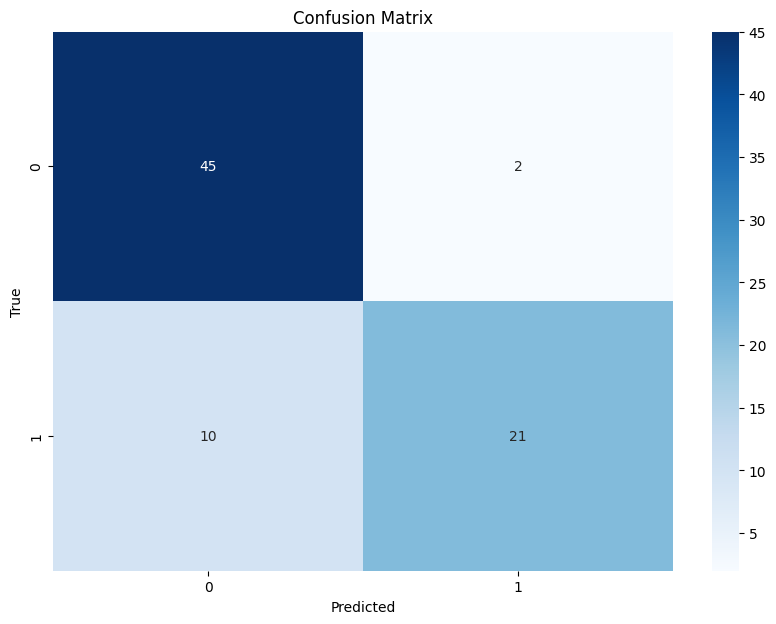


Classification Report for output1:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88        47
           1       0.91      0.68      0.78        31

    accuracy                           0.85        78
   macro avg       0.87      0.82      0.83        78
weighted avg       0.86      0.85      0.84        78


Confusion Matrix for output2:


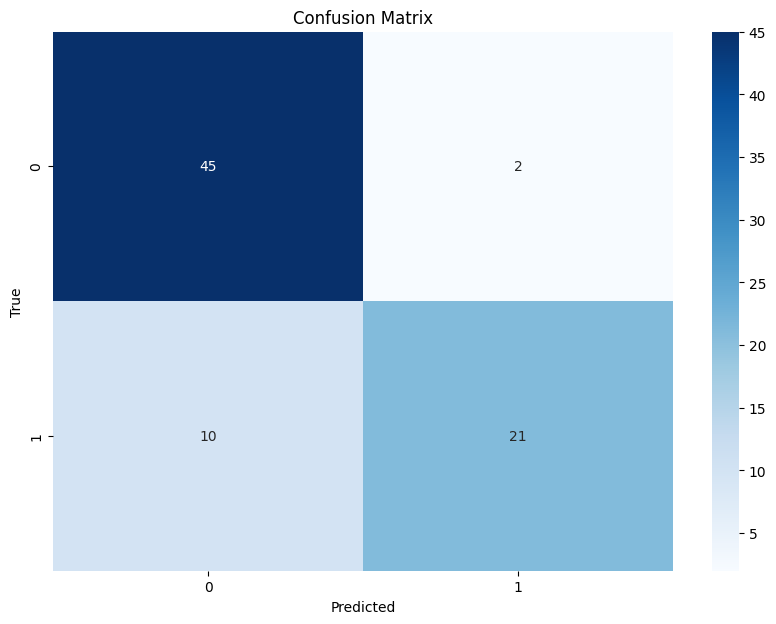


Classification Report for output2:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88        47
           1       0.91      0.68      0.78        31

    accuracy                           0.85        78
   macro avg       0.87      0.82      0.83        78
weighted avg       0.86      0.85      0.84        78


Class-wise Accuracy for output1: 84.62%

Class-wise Accuracy for output2: 84.62%


In [ ]:
#state_dict = torch.load('birads12-45_densenet_121_wdcc.pth')
#model.load_state_dict(state_dict)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

model.eval()
all_labels = []
all_preds1 = []
all_preds2 = []

with torch.no_grad():
    for (img1, img2), labels in tqdm(test_loader, desc="Testing", leave=False):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        output1, output2, _ = model(img1, img2, labels)
        pred1 = output1.argmax(dim=1)
        pred2 = output2.argmax(dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds1.extend(pred1.cpu().numpy())
        all_preds2.extend(pred2.cpu().numpy())


cm1 = confusion_matrix(all_labels, all_preds1)
print("\nConfusion Matrix for output1:")
plot_confusion_matrix(cm1, classes=[0, 1])  

print("\nClassification Report for output1:")
print(classification_report(all_labels, all_preds1, target_names=[str(i) for i in range(len(cm1))]))

cm2 = confusion_matrix(all_labels, all_preds2)
print("\nConfusion Matrix for output2:")
plot_confusion_matrix(cm2, classes=[0, 1])  

print("\nClassification Report for output2:")
print(classification_report(all_labels, all_preds2, target_names=[str(i) for i in range(len(cm2))]))

accuracy1 = accuracy_score(all_labels, all_preds1)
print(f"\nClass-wise Accuracy for output1: {accuracy1*100:.2f}%")
accuracy2 = accuracy_score(all_labels, all_preds2)
print(f"\nClass-wise Accuracy for output2: {accuracy2*100:.2f}%")

In [10]:
base_model = models.densenet161(pretrained=True) 
denseNet161model = CNN_DenseNet161(base_model).to(device)
num_epochs = 10 
learning_rate = 0.0001
best_val_loss = float('inf')  
optimizer = optim.Adam(denseNet161model.parameters(), lr=learning_rate)
best_model_path = "birads12-45_densenet_161_wdcc.pth"
denseNet161model

CNN_DenseNet161(
  (densenet_layer): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, m

In [11]:
model = denseNet161model

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for (img1, img2), labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        optimizer.zero_grad()
        output1, output2, _ = model(img1, img2, labels)
        loss1, loss2 = weight_loss(output1, output2, labels)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct1 = 0
        correct2 = 0
        total = 0
        
        for (img1, img2), labels in tqdm(valid_loader, desc="Validation", leave=False):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            output1, output2, _ = model(img1, img2, labels)
            loss1, loss2 = weight_loss(output1, output2, labels)
            val_loss += (loss1 + loss2).item()
            pred1 = output1.argmax(dim=1)
            pred2 = output2.argmax(dim=1)
            correct1 += (pred1 == labels).sum().item()
            correct2 += (pred2 == labels).sum().item()
            total += labels.size(0)
            
        avg_val_loss = val_loss / len(valid_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print("Best model saved!")
        
        print(f"Validation Loss: {val_loss/len(valid_loader):.4f}, "
              f"Accuracy1: {correct1/total*100:.2f}%, Accuracy2: {correct2/total*100:.2f}%")


Epoch [1/10], Loss: 1.3398


Best model saved!
Validation Loss: 1.0613, Accuracy1: 73.33%, Accuracy2: 73.33%



Epoch [2/10], Loss: 1.1601


Best model saved!
Validation Loss: 0.9065, Accuracy1: 80.67%, Accuracy2: 81.00%



Epoch [3/10], Loss: 1.0503


Best model saved!
Validation Loss: 0.8662, Accuracy1: 80.67%, Accuracy2: 80.33%



Epoch [4/10], Loss: 0.9855


Best model saved!
Validation Loss: 0.8348, Accuracy1: 81.67%, Accuracy2: 81.33%



Epoch [5/10], Loss: 0.9525


Validation Loss: 0.8455, Accuracy1: 82.33%, Accuracy2: 82.67%



Epoch [6/10], Loss: 0.9635


Validation Loss: 0.9102, Accuracy1: 79.00%, Accuracy2: 79.33%



Epoch [7/10], Loss: 0.9093


Validation Loss: 0.8553, Accuracy1: 81.00%, Accuracy2: 81.33%



Epoch [8/10], Loss: 0.8986


Best model saved!
Validation Loss: 0.7946, Accuracy1: 85.33%, Accuracy2: 85.33%



Epoch [9/10], Loss: 0.8459


Validation Loss: 0.8071, Accuracy1: 80.00%, Accuracy2: 80.00%



Epoch [10/10], Loss: 0.8314


Validation Loss: 0.8374, Accuracy1: 80.00%, Accuracy2: 80.00%



Confusion Matrix for output1:


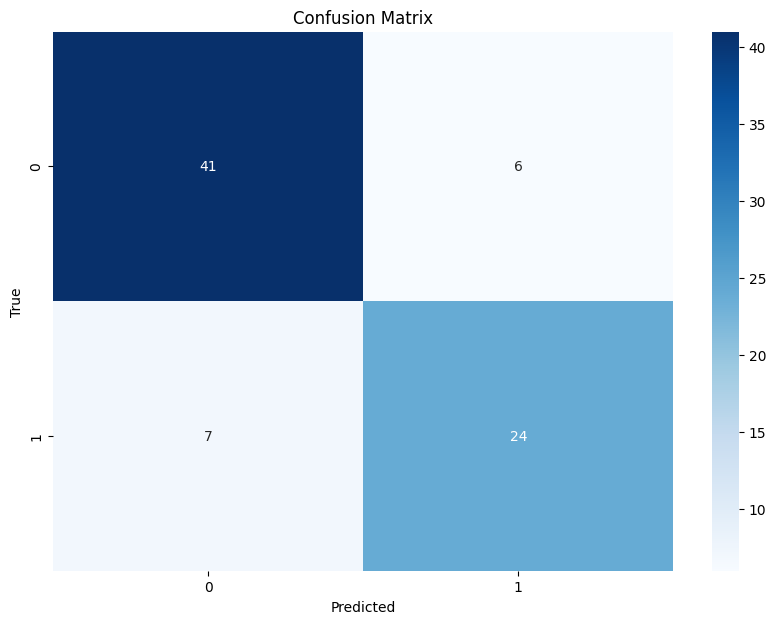


Classification Report for output1:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        47
           1       0.80      0.77      0.79        31

    accuracy                           0.83        78
   macro avg       0.83      0.82      0.83        78
weighted avg       0.83      0.83      0.83        78


Confusion Matrix for output2:


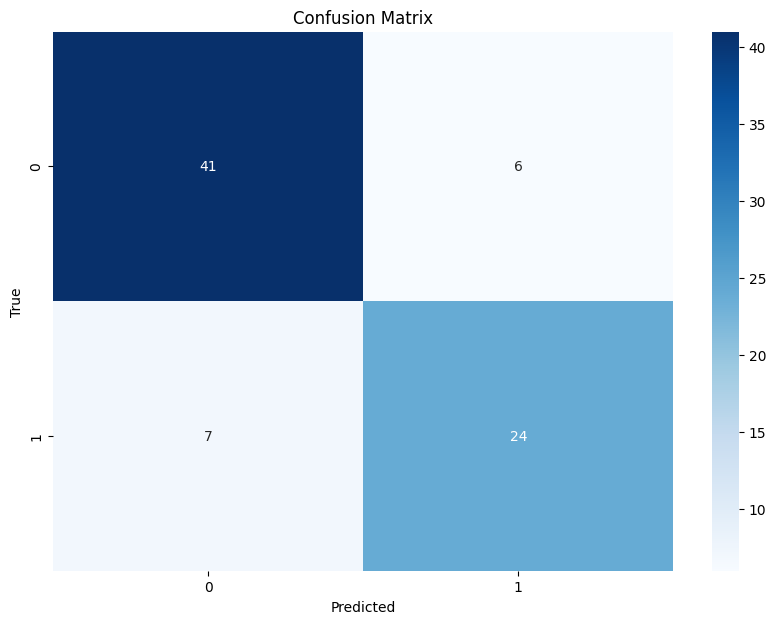


Classification Report for output2:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        47
           1       0.80      0.77      0.79        31

    accuracy                           0.83        78
   macro avg       0.83      0.82      0.83        78
weighted avg       0.83      0.83      0.83        78


Class-wise Accuracy for output1: 83.33%

Class-wise Accuracy for output2: 83.33%


In [ ]:
#state_dict = torch.load('birads12-45_densenet_161_wdcc.pth')
#model.load_state_dict(state_dict)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

model.eval()
all_labels = []
all_preds1 = []
all_preds2 = []

with torch.no_grad():
    for (img1, img2), labels in tqdm(test_loader, desc="Testing", leave=False):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        output1, output2, _ = model(img1, img2, labels)
        pred1 = output1.argmax(dim=1)
        pred2 = output2.argmax(dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds1.extend(pred1.cpu().numpy())
        all_preds2.extend(pred2.cpu().numpy())


cm1 = confusion_matrix(all_labels, all_preds1)
print("\nConfusion Matrix for output1:")
plot_confusion_matrix(cm1, classes=[0, 1])  

print("\nClassification Report for output1:")
print(classification_report(all_labels, all_preds1, target_names=[str(i) for i in range(len(cm1))]))

cm2 = confusion_matrix(all_labels, all_preds2)
print("\nConfusion Matrix for output2:")
plot_confusion_matrix(cm2, classes=[0, 1])  

print("\nClassification Report for output2:")
print(classification_report(all_labels, all_preds2, target_names=[str(i) for i in range(len(cm2))]))

accuracy1 = accuracy_score(all_labels, all_preds1)
print(f"\nClass-wise Accuracy for output1: {accuracy1*100:.2f}%")
accuracy2 = accuracy_score(all_labels, all_preds2)
print(f"\nClass-wise Accuracy for output2: {accuracy2*100:.2f}%")

### DenseNet121 and DenseNet161 with normal classifier head

In [15]:
class CNN_DenseNet121_2(nn.Module): 
    def __init__(self, model):
        super(CNN_DenseNet121_2, self).__init__()
        self.densenet_layer = nn.Sequential(*list(model.children())[:-1])
        self.avp_pooling = nn.AdaptiveAvgPool2d((1, 1)) 
        self.linear_layer1 = nn.Linear(2048, 1024) 
        self.linear_layer2 = nn.Linear(1024, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, img1, img2):
        # first image
        x1 = self.densenet_layer(img1)
        x1 = self.avp_pooling(x1).view(x1.size()[0], -1)

        # second image
        x2 = self.densenet_layer(img2)
        x2 = self.avp_pooling(x2).view(x2.size()[0], -1)

        x = torch.cat((x1, x2), dim=1)
        x = self.dropout(x)
        x = self.relu(self.linear_layer1(x))
        x = self.dropout(x)
        x = self.relu(self.linear_layer2(x))

        return x
    
class CNN_DenseNet161_2(nn.Module): 
    def __init__(self, model):
        super(CNN_DenseNet161_2, self).__init__()
        self.densenet_layer = nn.Sequential(*list(model.children())[:-1])
        self.avp_pooling = nn.AdaptiveAvgPool2d((1, 1)) 
        self.linear_layer1 = nn.Linear(4416, 1024) 
        self.linear_layer2 = nn.Linear(1024, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, img1, img2):
        # first image
        x1 = self.densenet_layer(img1)
        x1 = self.avp_pooling(x1).view(x1.size()[0], -1)

        # second image
        x2 = self.densenet_layer(img2)
        x2 = self.avp_pooling(x2).view(x2.size()[0], -1)

        x = torch.cat((x1, x2), dim=1)
        x = self.dropout(x)
        x = self.relu(self.linear_layer1(x))
        x = self.dropout(x)
        x = self.relu(self.linear_layer2(x))

        return x

In [9]:
base_model = models.densenet121(pretrained=True) 
denseNet121model2 = CNN_DenseNet121_2(base_model).to(device)
model2 = denseNet121model2
num_epochs = 10 
learning_rate = 0.0001
best_val_loss = float('inf')  
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
best_model_path = "birads12-45_densenet121_normal.pth"
criterion = torch.nn.CrossEntropyLoss()
model2

CNN_DenseNet121_2(
  (densenet_layer): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, 

In [10]:
for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    
    for (img1, img2), labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]"):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model2(img1, img2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")
    
    # Validation loop
    model2.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for (img1, img2), labels in tqdm(valid_loader, desc="Validation"):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model2(img1, img2)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(valid_loader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model2.state_dict(), best_model_path)
        print("Best model saved!")

print("Training finished!")

Epoch [1/10]: 100%|██████████| 293/293 [06:57<00:00,  1.43s/it]


Epoch [1/10], Train Loss: 0.6235


Validation: 100%|██████████| 38/38 [00:21<00:00,  1.80it/s]


Validation Loss: 0.6178, Accuracy: 59.67%
Best model saved!


Epoch [2/10]: 100%|██████████| 293/293 [06:44<00:00,  1.38s/it]


Epoch [2/10], Train Loss: 0.5776


Validation: 100%|██████████| 38/38 [00:20<00:00,  1.86it/s]


Validation Loss: 0.6092, Accuracy: 59.67%
Best model saved!


Epoch [3/10]: 100%|██████████| 293/293 [06:44<00:00,  1.38s/it]


Epoch [3/10], Train Loss: 0.5692


Validation: 100%|██████████| 38/38 [00:20<00:00,  1.88it/s]


Validation Loss: 0.5846, Accuracy: 59.67%
Best model saved!


Epoch [4/10]: 100%|██████████| 293/293 [06:45<00:00,  1.38s/it]


Epoch [4/10], Train Loss: 0.5429


Validation: 100%|██████████| 38/38 [00:20<00:00,  1.88it/s]


Validation Loss: 0.5621, Accuracy: 59.67%
Best model saved!


Epoch [5/10]: 100%|██████████| 293/293 [06:44<00:00,  1.38s/it]


Epoch [5/10], Train Loss: 0.5335


Validation: 100%|██████████| 38/38 [00:20<00:00,  1.88it/s]


Validation Loss: 0.5368, Accuracy: 59.67%
Best model saved!


Epoch [6/10]: 100%|██████████| 293/293 [06:44<00:00,  1.38s/it]


Epoch [6/10], Train Loss: 0.5120


Validation: 100%|██████████| 38/38 [00:20<00:00,  1.87it/s]


Validation Loss: 0.5102, Accuracy: 59.67%
Best model saved!


Epoch [7/10]: 100%|██████████| 293/293 [06:44<00:00,  1.38s/it]


Epoch [7/10], Train Loss: 0.5149


Validation: 100%|██████████| 38/38 [00:20<00:00,  1.87it/s]


Validation Loss: 0.5330, Accuracy: 59.67%


Epoch [8/10]:  35%|███▌      | 103/293 [02:21<04:21,  1.38s/it]


KeyboardInterrupt: 

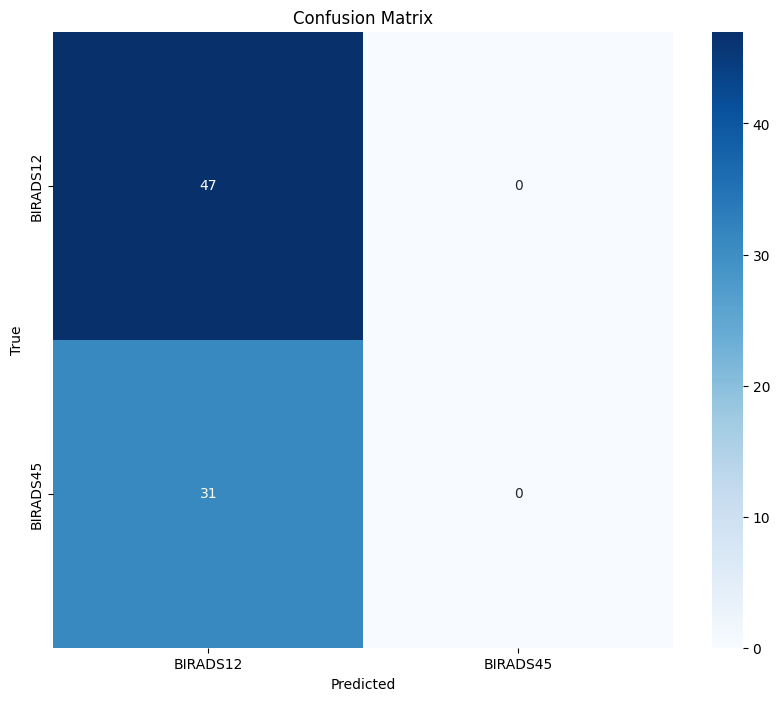

              precision    recall  f1-score   support

    BIRADS12       0.60      1.00      0.75        47
    BIRADS45       0.00      0.00      0.00        31

    accuracy                           0.60        78
   macro avg       0.30      0.50      0.38        78
weighted avg       0.36      0.60      0.45        78

Overall Accuracy: 0.6026
Accuracy for class BIRADS12: 1.0000
Accuracy for class BIRADS45: 0.0000


In [ ]:
y_true = []
y_pred = []

#state_dict = torch.load('birads12-45_densenet121_normal.pth')
#model2.load_state_dict(state_dict)

model2.eval()

class_names = ['BIRADS12', 'BIRADS45']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, labels in test_loader:
        
        inputs = [img.to(device) for img in inputs]
        labels = labels.to(device)
        
        outputs = model2(inputs[0], inputs[1])
        _, preds = torch.max(outputs, 1)
    
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))
accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f'Overall Accuracy: {accuracy:.4f}')
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f'Accuracy for class {class_names[i]}: {acc:.4f}')

In [16]:
base_model = models.densenet161(pretrained=True) 
denseNet161model2 = CNN_DenseNet161_2(base_model).to(device)
num_epochs = 10 
learning_rate = 0.0001
best_val_loss = float('inf')  
optimizer = optim.Adam(denseNet161model2.parameters(), lr=learning_rate)
best_model_path = "birads12-45_densenet_161_normal.pth"
criterion = torch.nn.CrossEntropyLoss()
denseNet161model2

CNN_DenseNet161_2(
  (densenet_layer): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05,

In [17]:
model2 = denseNet161model2

for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    
    for (img1, img2), labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]"):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model2(img1, img2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")
    
    # Validation loop
    model2.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for (img1, img2), labels in tqdm(valid_loader, desc="Validation"):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model2(img1, img2)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(valid_loader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model2.state_dict(), best_model_path)
        print("Best model saved!")

print("Training finished!")

Epoch [1/10]: 100%|██████████| 585/585 [08:58<00:00,  1.09it/s]


Epoch [1/10], Train Loss: 0.6445


Validation: 100%|██████████| 75/75 [00:25<00:00,  2.97it/s]


Validation Loss: 0.6539, Accuracy: 59.67%
Best model saved!


Epoch [2/10]: 100%|██████████| 585/585 [08:57<00:00,  1.09it/s]


Epoch [2/10], Train Loss: 0.6216


Validation: 100%|██████████| 75/75 [00:25<00:00,  2.98it/s]


Validation Loss: 0.6737, Accuracy: 59.67%


Epoch [3/10]: 100%|██████████| 585/585 [08:57<00:00,  1.09it/s]


Epoch [3/10], Train Loss: 0.6150


Validation: 100%|██████████| 75/75 [00:25<00:00,  2.98it/s]


Validation Loss: 0.6301, Accuracy: 59.67%
Best model saved!


Epoch [4/10]: 100%|██████████| 585/585 [08:57<00:00,  1.09it/s]


Epoch [4/10], Train Loss: 0.6093


Validation: 100%|██████████| 75/75 [00:25<00:00,  2.96it/s]


Validation Loss: 0.6278, Accuracy: 59.67%
Best model saved!


Epoch [5/10]: 100%|██████████| 585/585 [08:58<00:00,  1.09it/s]


Epoch [5/10], Train Loss: 0.6177


Validation: 100%|██████████| 75/75 [00:25<00:00,  2.96it/s]


Validation Loss: 0.6000, Accuracy: 59.67%
Best model saved!


Epoch [6/10]: 100%|██████████| 585/585 [08:57<00:00,  1.09it/s]


Epoch [6/10], Train Loss: 0.5987


Validation: 100%|██████████| 75/75 [00:25<00:00,  2.98it/s]


Validation Loss: 0.5708, Accuracy: 59.67%
Best model saved!


Epoch [7/10]: 100%|██████████| 585/585 [08:57<00:00,  1.09it/s]


Epoch [7/10], Train Loss: 0.6003


Validation: 100%|██████████| 75/75 [00:25<00:00,  2.96it/s]


Validation Loss: 0.5944, Accuracy: 59.67%


Epoch [8/10]: 100%|██████████| 585/585 [08:56<00:00,  1.09it/s]


Epoch [8/10], Train Loss: 0.5851


Validation: 100%|██████████| 75/75 [00:25<00:00,  2.97it/s]


Validation Loss: 0.6461, Accuracy: 59.67%


Epoch [9/10]: 100%|██████████| 585/585 [08:56<00:00,  1.09it/s]


Epoch [9/10], Train Loss: 0.5978


Validation: 100%|██████████| 75/75 [00:25<00:00,  2.98it/s]


Validation Loss: 0.5687, Accuracy: 59.67%
Best model saved!


Epoch [10/10]: 100%|██████████| 585/585 [08:56<00:00,  1.09it/s]


Epoch [10/10], Train Loss: 0.5714


Validation: 100%|██████████| 75/75 [00:25<00:00,  2.95it/s]

Validation Loss: 0.5600, Accuracy: 59.67%
Best model saved!
Training finished!


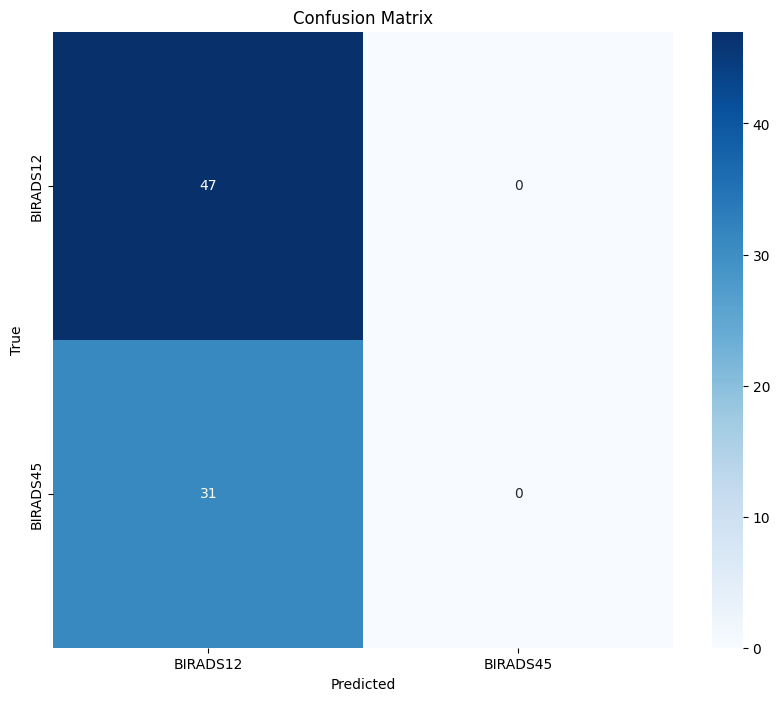

              precision    recall  f1-score   support

    BIRADS12       0.60      1.00      0.75        47
    BIRADS45       0.00      0.00      0.00        31

    accuracy                           0.60        78
   macro avg       0.30      0.50      0.38        78
weighted avg       0.36      0.60      0.45        78

Overall Accuracy: 0.6026
Accuracy for class BIRADS12: 1.0000
Accuracy for class BIRADS45: 0.0000


: 

In [ ]:
y_true = []
y_pred = []

#state_dict = torch.load('birads12-45_densenet_161_normal.pth')
#model2.load_state_dict(state_dict)

model2.eval()

class_names = ['BIRADS12', 'BIRADS45']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, labels in test_loader:
        
        inputs = [img.to(device) for img in inputs]
        labels = labels.to(device)
        
        outputs = model2(inputs[0], inputs[1])
        _, preds = torch.max(outputs, 1)
    
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))
accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f'Overall Accuracy: {accuracy:.4f}')
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f'Accuracy for class {class_names[i]}: {acc:.4f}')